In [370]:
import collections
import itertools as it
import json
import re

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import numpy as np
import torch

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [107]:
results = collections.defaultdict(lambda: collections.defaultdict(lambda: [[], [], []]))
with open("/tmp/gridsearch_results.txt", "rt") as f:
    for i, l in enumerate(f):
        if i < 1000:
            continue  # Ignore warmup
        
        entry = json.loads(l.strip())
        impl, c_in, c_out, image_h, image_w, delta_ns = [entry[i] for i in ("choice", "c_in", "c_out", "image_h", "image_w", "delta_ns")]

        results[(image_h, image_w)][(c_in, c_out)][impl].append(delta_ns)

bounds = {
    k: [[np.inf, np.inf], [-np.inf, -np.inf]]
    for k in results
}

for k, r in results.items():
    for c_in, c_out in r:
        bounds[k][0][0] =  min(bounds[k][0][0], c_in)
        bounds[k][0][1] =  min(bounds[k][0][0], c_out)
        bounds[k][1][0] =  max(bounds[k][1][0], c_in)
        bounds[k][1][1] =  max(bounds[k][1][0], c_out)

    assert(bounds[k][0][0] >= 0)
    assert(bounds[k][0][1] >= 0)

In [108]:
border_map = {
    k: np.ones((bounds[k][1][0] + 2, bounds[k][1][1] + 2, 3))
    for k in results
}

# These parameters control the brightness and contrast of the image
max_scale = 1.2
offset = 0.5

for k, r in results.items():
    count = 0
    best_counts = [0, 0, 0]

    for (c_in, c_out), v in r.items():
        if all(v):
            v = np.array([np.mean(vi) for vi in v])
            v /= np.min(v)
            v -= offset
            v = max_scale / v

            best_counts[np.argmin(v)] += 1
            count += 1

            border_map[k][c_in, c_out, :] = torch.softmax(torch.Tensor(v), dim=0).numpy()

    print(count)
    print(k, best_counts)

9215
(128, 128) [2452, 4643, 2120]


1 / 9604 points interpolated


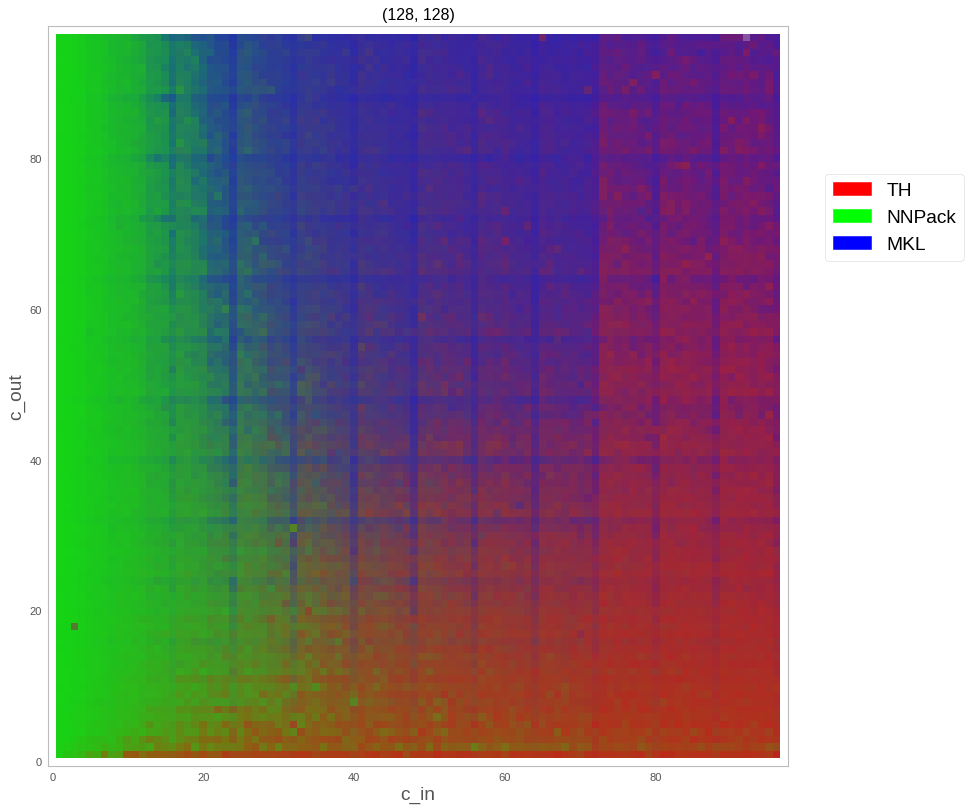

In [109]:
fig = plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
subplot_w = int(np.ceil(np.sqrt(len(results))))
subplot_h = int(np.ceil(len(results) / subplot_w))
for i, k in enumerate(sorted(border_map.keys())):
    bm = border_map[k]
    
    # Interpolate missing points
    bm = bm.copy()
    ind_to_interpolate = []
    for index_0 in range(1, bm.shape[0] - 1):
        for index_1 in range(1, bm.shape[1] - 1):
            if sum(bm[index_0, index_1, :]) == 3:
                ind_to_interpolate.append((index_0, index_1))
    for index_0, index_1 in ind_to_interpolate * 5:
        bm[index_0, index_1, :] = (
            bm[index_0 - 1, index_1, :] +
            bm[index_0 + 1, index_1, :] +
            bm[index_0, index_1 - 1, :] +
            bm[index_0, index_1 + 1, :]) / 4
        
    print(f"{len(ind_to_interpolate)} / {bm.shape[0] * bm.shape[1]} points interpolated")
    
    plt.subplot(subplot_h, subplot_w, i + 1)
    plt.imshow(bm, interpolation="none", origin="lower")
    plt.grid(None)
    plt.xlabel("c_in", fontsize="xx-large")
    plt.ylabel("c_out", fontsize="xx-large")
    plt.title(str(k))

patches = [mpatches.Patch(color=c, label=l) for c, l in (([1, 0, 0], "TH"), ([0, 1, 0], "NNPack"), ([0, 0, 1], "MKL"))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0. , fontsize="xx-large")
fig.tight_layout()

In [177]:
drilldown_results = collections.defaultdict(lambda: [[], [], []])
with open("/tmp/drilldown_results.txt", "rt") as f:
    for i, l in enumerate(f):
        if i < 1000:
            continue  # Ignore warmup
            
        entry = json.loads(l.strip())
        impl, c_in, c_out, image_h, image_w, delta_ns = [entry[i] for i in ("choice", "c_in", "c_out", "image_h", "image_w", "delta_ns")]
        assert (image_h, image_w) == (128, 128)
#         assert (image_h, image_w) == (64, 64)
        drilldown_results[(c_in, c_out)][impl].append(delta_ns)

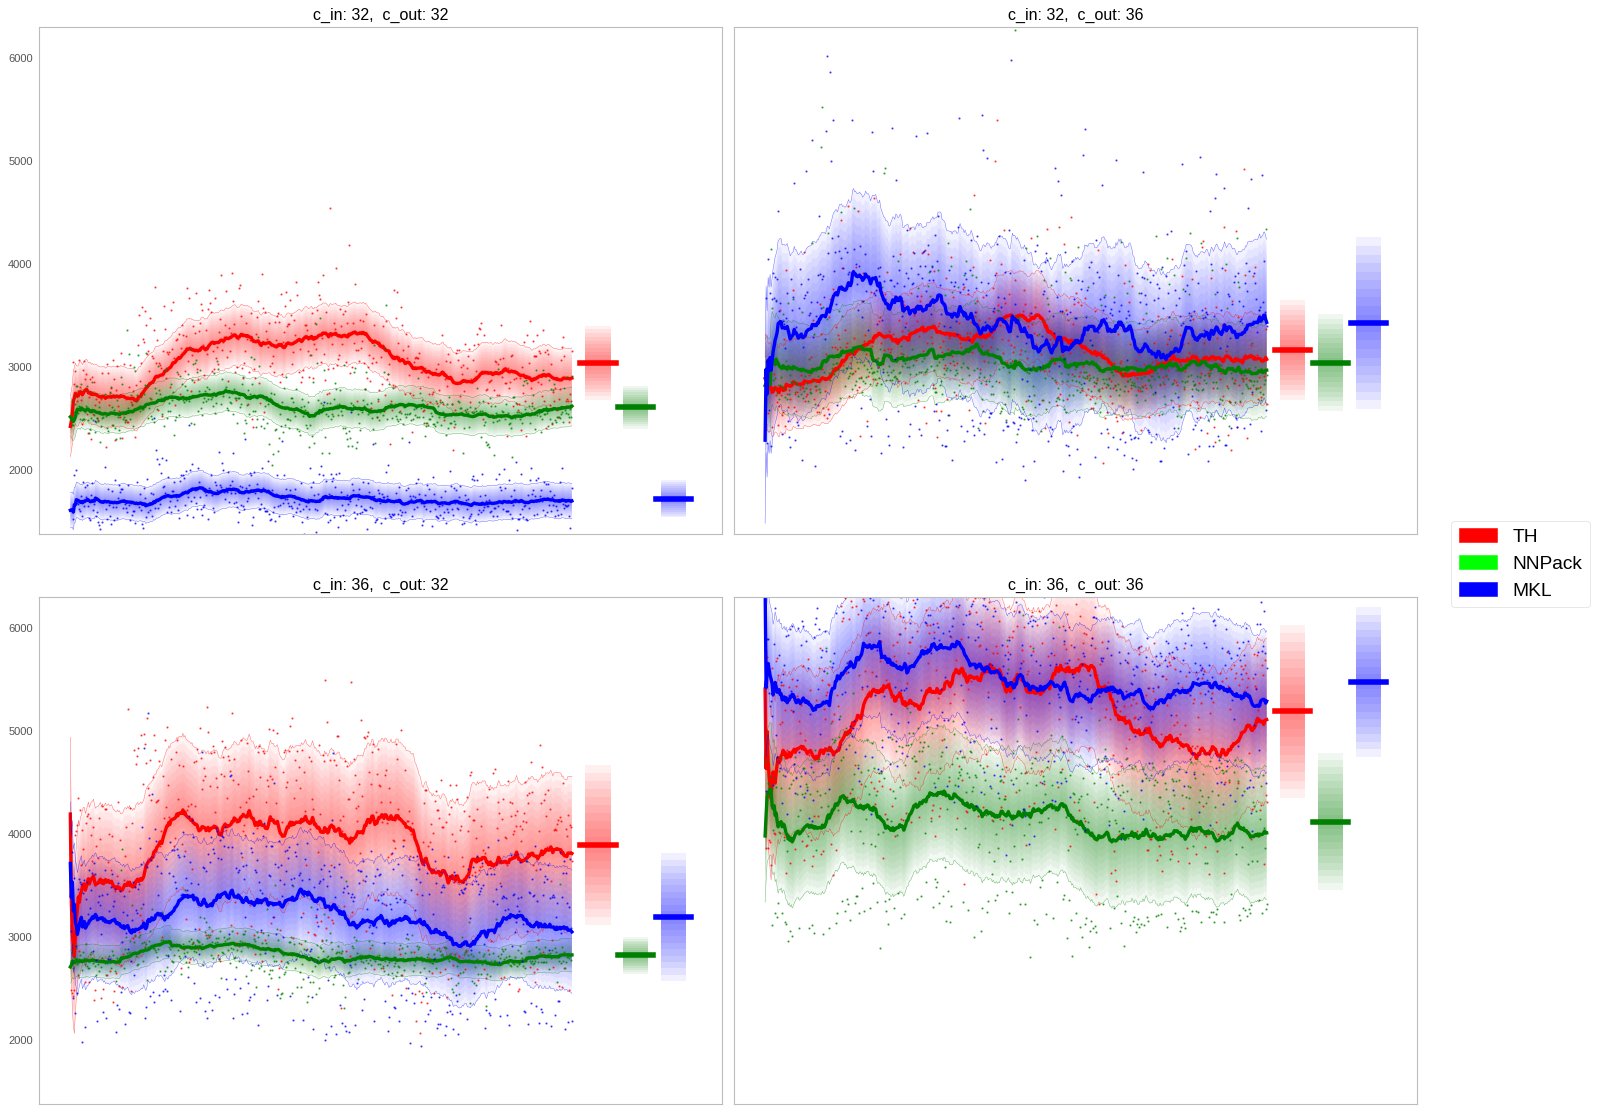

In [178]:
window = 50

n = 500
flat_values = list(it.chain(*it.chain(*drilldown_results.values())))
y_min = np.percentile(flat_values, 0.01) * 1e-3
y_max = np.percentile(flat_values, 98) * 1e-3

fig = plt.figure(figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
drilldown_keys = sorted(drilldown_results.keys())
subplot_w = int(np.ceil(np.sqrt(len(drilldown_keys))))
subplot_h = int(np.ceil(len(drilldown_keys) / subplot_w))
for drilldown_index, (c_in, c_out) in enumerate(drilldown_keys):
    plt.subplot(subplot_h, subplot_w, drilldown_index + 1)
    for j, color in enumerate(["r", "g", "b"]):
        y = np.array(drilldown_results[(c_in, c_out)][j][:n]) * 1e-3
    
        running_mean, running_std = [], []
        for i in range(len(y)):
            y_subset = y[max(0, i + 1 - window):i + 1]
            running_mean.append(np.mean(y_subset))
            running_std.append(np.std(y_subset))
        running_mean, running_std = np.array(running_mean), np.mean(running_std)
        
        plt.plot(y, "." + color, markersize=2, alpha=0.6)
        plt.plot(running_mean, color, linewidth=3)
        
        shade_k = 3
        for i in range(1, shade_k + 1):
            y_lower = running_mean - running_std * i / shade_k
            y_upper = running_mean + running_std * i / shade_k
            plt.fill_between(np.arange(n), y_lower, y_upper, facecolor=color, alpha=0.5/shade_k)
            
            plt.fill_between(
                n * 1.025 + j * n * 0.075 + np.array([0, n * 0.05]),
                [np.mean(y) - np.std(y) * i / shade_k] * 2,
                [np.mean(y) + np.std(y) * i / shade_k] * 2,
                facecolor=color,
                alpha=0.6/shade_k,
            )
        plt.plot(y_lower, "-" + color, linewidth=0.4, alpha=0.6)
        plt.plot(y_upper, "-" + color, linewidth=0.4, alpha=0.6)
        plt.plot(n * 1.025 + j * n * 0.075 + np.array([-n * 0.01, n * 0.06]), [np.mean(y)] * 2, color=color, linewidth=5)
        

    plt.title(f"c_in: {c_in},  c_out: {c_out}")
    plt.ylim(bottom=y_min, top=y_max)
    plt.grid(None)
    
    plt.gca().axes.get_xaxis().set_visible(False)
    if drilldown_index % subplot_w:
        plt.gca().axes.get_yaxis().set_visible(False)

patches = [mpatches.Patch(color=c, label=l) for c, l in (([1, 0, 0], "TH"), ([0, 1, 0], "NNPack"), ([0, 0, 1], "MKL"))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.15), loc=2, borderaxespad=0. , fontsize="xx-large")
fig.tight_layout()

In [354]:
torchvision_trials = []
with open("/tmp/torchvision_results.txt", "rt") as f:
    for l in f:
        trial = json.loads(l.strip())
        torchvision_trials.append(trial)

for key, y in torchvision_trials:
    y["delta"] = np.mean(y["on"]) / np.mean(y["off"]) - 1.0
    
torchvision_trials.sort(key=lambda x: -x[1]["delta"])

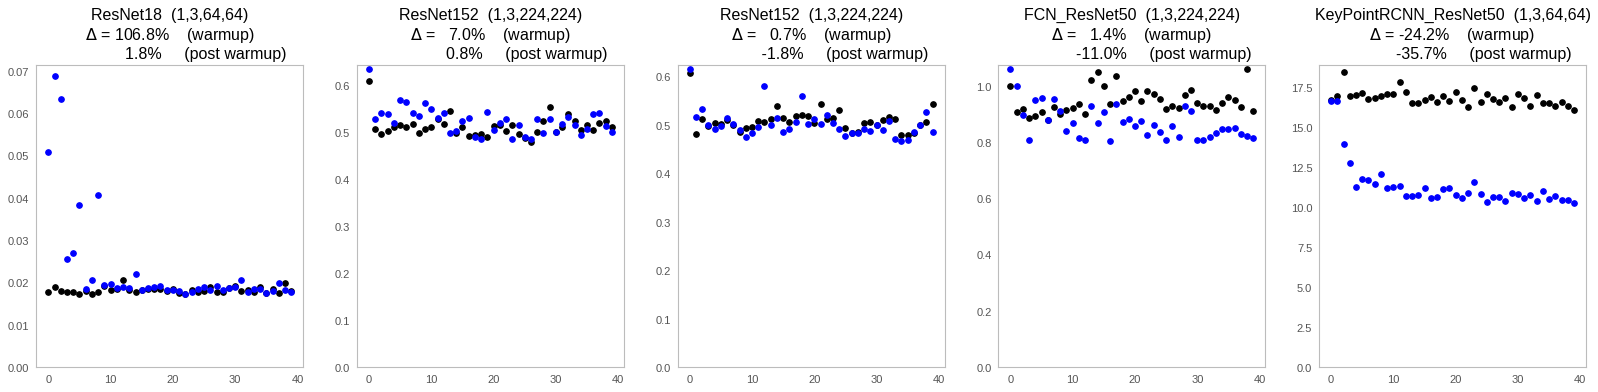

In [355]:
n = 5
fig = plt.figure(figsize=(5 * n, 5), dpi=80, facecolor='w', edgecolor='k')
for i, index in enumerate([int(ind) for ind in np.linspace(0, len(torchvision_trials) - 1, n)]):
    ax = plt.subplot(1, n, i + 1)
    ax.grid(False)
    (model, size), y = torchvision_trials[index]
    warmup_delta =  np.mean(y["on"][:10]) / np.mean(y["off"][:10]) - 1.0
    post_warmup_delta =  np.mean(y["on"][10:]) / np.mean(y["off"][10:]) - 1.0
    plt.plot(y["off"], ".k", markersize=10)
    plt.plot(y["on"], ".b", markersize=10)
    plt.ylim(bottom=0)
    plt.title(
        f"{model}  ({size})\n"
        f"$\Delta$ = {warmup_delta * 100:>5.1f}%    (warmup)\n"
        f"{'':>14}{post_warmup_delta * 100:>5.1f}%     (post warmup)",
    )

(-40, 110)

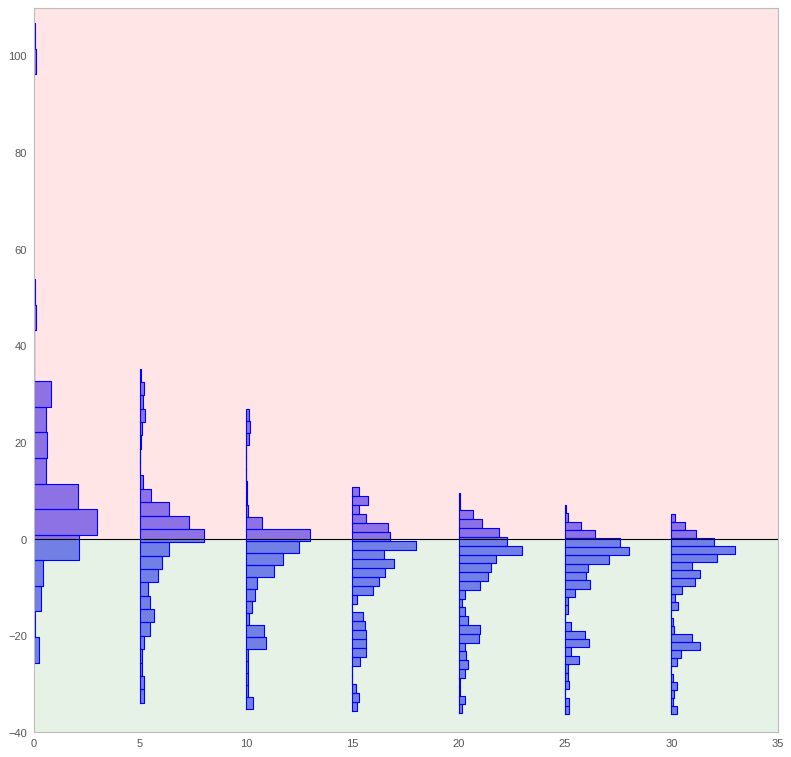

In [360]:
n_max = 30
fig = plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot([0, n_max + 5], [0, 0], "k", linewidth=1)
plt.grid(False)

y_min, y_max = np.inf, -np.inf
for offset in range(0, n_max + 1, 5):
    deltas = []
    for _, y in torchvision_trials:
        delta = np.mean(y["on"][offset:offset+10]) / np.mean(y["off"][offset:offset+10]) - 1.0
        deltas.append(delta * 100)
    x, y = np.histogram(deltas, bins=25, density=True)
    x = x / np.max(x) * 3
    x += offset
    for i, xi in enumerate(x):
        if not xi:
            continue
        plt.fill_between(
            [offset, xi],
            [y[i]] * 2, 
            [y[i+1]] * 2,
            facecolor="b",
            alpha=0.5
        )
        plt.plot(
            [offset] + [xi] * 2 +  [offset] * 2,
            [y[i]] * 2 + [y[i+1]] * 2 + [y[i]],
            "b"
        )
    y_min = min(y_min, np.min(y))
    y_max = max(y_max, np.max(y))
y_min = int(y_min // 10) * 10
y_max = int(np.ceil(y_max / 10)) * 10
plt.fill_between([0, n_max + 5], [0, 0], [y_min, y_min], facecolor="g", alpha=0.1)
plt.fill_between([0, n_max + 5], [0, 0], [y_max, y_max], facecolor="r", alpha=0.1)
plt.xlim(0, n_max + 5)
plt.ylim(y_min, y_max)


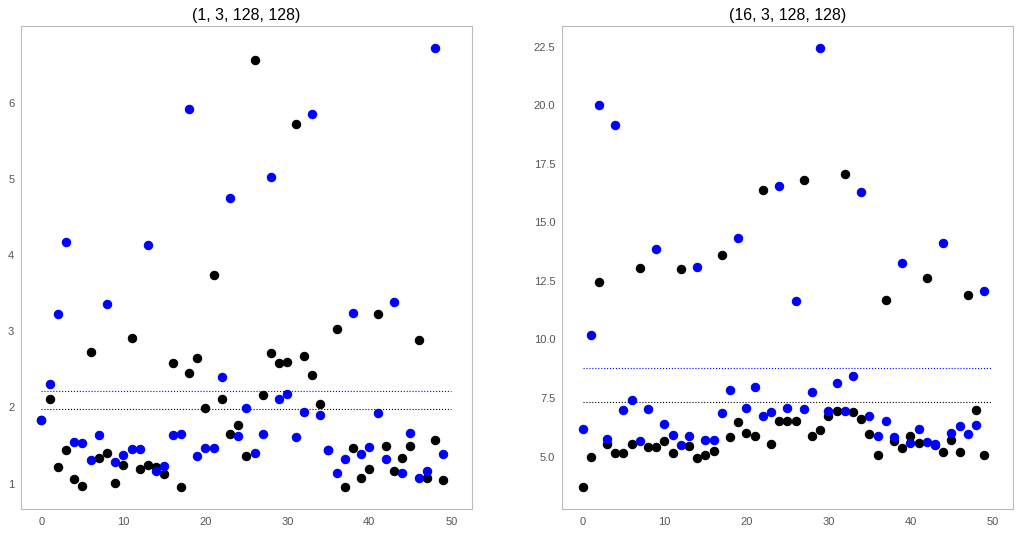

In [534]:
raw_gan_results = {(1, 3, 128, 128): [('off', 1.826566219329834), ('on', 1.823775291442871), ('off', 2.1063129901885986), ('on', 2.301671266555786), ('off', 1.2119708061218262), ('on', 3.2158632278442383), ('off', 1.428347110748291), ('on', 4.1668102741241455), ('off', 1.0521235466003418), ('on', 1.5457179546356201), ('off', 0.9612579345703125), ('on', 1.5276572704315186), ('off', 2.7193310260772705), ('on', 1.3009157180786133), ('off', 1.324082374572754), ('on', 1.6364774703979492), ('off', 1.3997845649719238), ('on', 3.3454887866973877), ('off', 1.0046253204345703), ('on', 1.275639533996582), ('off', 1.2355756759643555), ('on', 1.3725950717926025), ('off', 2.9074339866638184), ('on', 1.454197883605957), ('off', 1.1834495067596436), ('on', 1.4415991306304932), ('off', 1.236816167831421), ('on', 4.129850149154663), ('off', 1.210693597793579), ('on', 1.1546778678894043), ('off', 1.119863510131836), ('on', 1.2286577224731445), ('off', 2.575653314590454), ('on', 1.6272451877593994), ('off', 0.9501204490661621), ('on', 1.651242733001709), ('off', 2.4507808685302734), ('on', 5.9090845584869385), ('off', 2.6386337280273438), ('on', 1.356827735900879), ('off', 1.9859788417816162), ('on', 1.463324785232544), ('off', 3.733281373977661), ('on', 1.4618556499481201), ('off', 2.10054612159729), ('on', 2.387345552444458), ('off', 1.6450135707855225), ('on', 4.746103286743164), ('off', 1.7669036388397217), ('on', 1.6194303035736084), ('off', 1.3497517108917236), ('on', 1.9911415576934814), ('off', 6.54658055305481), ('on', 1.397343397140503), ('off', 2.1540677547454834), ('on', 1.649298906326294), ('off', 2.7090601921081543), ('on', 5.01189112663269), ('off', 2.573812484741211), ('on', 2.103822708129883), ('off', 2.5939841270446777), ('on', 2.174468994140625), ('off', 5.70453143119812), ('on', 1.6008398532867432), ('off', 2.67279314994812), ('on', 1.9277708530426025), ('off', 2.4133806228637695), ('on', 5.841324329376221), ('off', 2.0348691940307617), ('on', 1.898711919784546), ('off', 1.432722806930542), ('on', 1.4400770664215088), ('off', 3.025020122528076), ('on', 1.133866548538208), ('off', 0.9446361064910889), ('on', 1.3190126419067383), ('off', 1.4635207653045654), ('on', 3.2299420833587646), ('off', 1.0683441162109375), ('on', 1.3797943592071533), ('off', 1.1884419918060303), ('on', 1.467682123184204), ('off', 3.2238733768463135), ('on', 1.9158844947814941), ('off', 1.4892144203186035), ('on', 1.315894603729248), ('off', 1.1537871360778809), ('on', 3.378803014755249), ('off', 1.3324854373931885), ('on', 1.13885498046875), ('off', 1.4847290515899658), ('on', 1.6575806140899658), ('off', 2.87882137298584), ('on', 1.0654985904693604), ('off', 1.0673761367797852), ('on', 1.1637113094329834), ('off', 1.5628418922424316), ('on', 6.706726789474487), ('off', 1.040644884109497), ('on', 1.3819208145141602)], (16, 3, 128, 128): [('off', 3.658972978591919), ('on', 6.156219005584717), ('off', 4.941064357757568), ('on', 10.189103364944458), ('off', 12.412363529205322), ('on', 19.97552800178528), ('off', 5.495834589004517), ('on', 5.7429304122924805), ('off', 5.132152318954468), ('on', 19.148754596710205), ('off', 5.108865261077881), ('on', 6.962219476699829), ('off', 5.526687383651733), ('on', 7.3924806118011475), ('off', 13.015397548675537), ('on', 5.651588201522827), ('off', 5.39679217338562), ('on', 7.0165627002716064), ('off', 5.384427785873413), ('on', 13.832157611846924), ('off', 5.653080701828003), ('on', 6.38312292098999), ('off', 5.11105751991272), ('on', 5.877537250518799), ('off', 12.975754976272583), ('on', 5.484551668167114), ('off', 5.419119358062744), ('on', 5.869078159332275), ('off', 4.915301561355591), ('on', 13.09044361114502), ('off', 5.038949489593506), ('on', 5.667543172836304), ('off', 5.226877212524414), ('on', 5.669817924499512), ('off', 13.60647177696228), ('on', 6.836871862411499), ('off', 5.8252527713775635), ('on', 7.814336061477661), ('off', 6.469258546829224), ('on', 14.322463750839233), ('off', 5.972801208496094), ('on', 7.057214260101318), ('off', 5.838233232498169), ('on', 7.949613094329834), ('off', 16.34355664253235), ('on', 6.694687366485596), ('off', 5.506004095077515), ('on', 6.880406856536865), ('off', 6.50656533241272), ('on', 16.553740978240967), ('off', 6.506818056106567), ('on', 7.066921949386597), ('off', 6.500211715698242), ('on', 11.628737211227417), ('off', 16.78352952003479), ('on', 7.018364667892456), ('off', 5.8341004848480225), ('on', 7.737134218215942), ('off', 6.093404293060303), ('on', 22.427284479141235), ('off', 6.725200414657593), ('on', 6.936084032058716), ('off', 6.913669109344482), ('on', 8.119260311126709), ('off', 17.036696672439575), ('on', 6.907189130783081), ('off', 6.888974905014038), ('on', 8.40076494216919), ('off', 6.599761009216309), ('on', 16.27463960647583), ('off', 5.930621385574341), ('on', 6.715211391448975), ('off', 5.056260824203491), ('on', 5.850647926330566), ('off', 11.665631532669067), ('on', 6.515652894973755), ('off', 5.6532933712005615), ('on', 5.81260347366333), ('off', 5.344459056854248), ('on', 13.262718200683594), ('off', 5.849668502807617), ('on', 5.536432981491089), ('off', 5.558027744293213), ('on', 6.165848016738892), ('off', 12.618383407592773), ('on', 5.617582082748413), ('off', 5.461585521697998), ('on', 5.493983745574951), ('off', 5.154479265213013), ('on', 14.110532999038696), ('off', 5.684630632400513), ('on', 6.0006444454193115), ('off', 5.1603710651397705), ('on', 6.267834424972534), ('off', 11.884447813034058), ('on', 5.9201459884643555), ('off', 6.943633079528809), ('on', 6.33164119720459), ('off', 5.025026321411133), ('on', 12.028831958770752)]}

results = {k: [[], []] for k in raw_results}
for k, v in raw_gan_results.items():
    for autotune, t in v:
        results[k][autotune == "on"].append(t)

fig = plt.figure(figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
for i, size in enumerate(results.keys()):
    plt.subplot(1, 2, i + 1)
    plt.title(size)
    plt.grid(False)
    
    for i, color in enumerate(["k", "b"]):
        y = results[size][i]
        plt.plot(y, "." + color, markersize=15)
        plt.plot([0, len(y)], [np.mean(y)] * 2, ":" + color)

(0, 17.856906055752187)

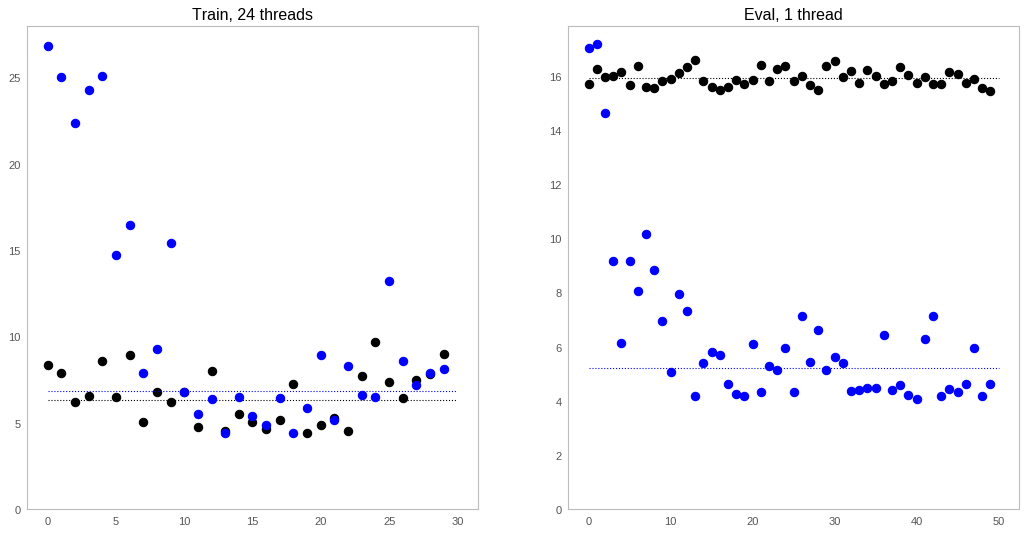

In [561]:
raw_unet_results = [
    {'on': [26.877210788428783, 25.070091519504786, 22.389055151492357, 24.321420539170504, 25.08797504939139, 14.722414433956146], 'off': [8.369749907404184, 7.904933575540781, 6.200475946068764, 6.542965784668922, 8.618217753246427, 6.514324115589261]},
    {'on': [16.479596382007003, 7.880359495058656, 9.293702390044928, 15.45057817734778, 6.797512734308839, 5.54643140360713], 'off': [8.917332032695413, 5.044848380610347, 6.820223933085799, 6.203574646264315, 6.810948375612497, 4.788952104747295]},
    {'on': [6.395408419892192, 4.399021107703447, 6.485813779756427, 5.43238147161901, 4.912357676774263, 6.46192398108542], 'off': [8.019096797332168, 4.5346859991550446, 5.547763880342245, 5.070816507562995, 4.656510228291154, 5.152682472020388]},
    {'on': [4.4021631851792336, 5.8499972354620695, 8.96978242881596, 5.157176906242967, 8.30695548094809, 6.627366315573454], 'off': [7.273144848644733, 4.4087597243487835, 4.91272185370326, 5.321146674454212, 4.551202388480306, 7.711949216201901]},
    {'on': [6.48330014385283, 13.240127000957727, 8.569408915936947, 7.22253648750484, 7.906844012439251, 8.106393199414015], 'off': [9.723829800263047, 7.4022952523082495, 6.454149166122079, 7.480882855132222, 7.860810209065676, 9.00098336674273]},
]

results = [[], []]
for r in raw_unet_results:
    results[0].extend(r["off"])
    results[1].extend(r["on"])
    
unet_eval_results = {'on': [17.06632454879582, 17.199971303343773, 14.655194956809282, 9.189318474382162, 6.160315360873938, 9.193824149668217, 8.075283609330654, 10.166604399681091, 8.846037266775966, 6.9414825309067965, 5.062770392745733, 7.974481295794249, 7.31229904666543, 4.171069633215666, 5.404417863115668, 5.8159164767712355, 5.706872425973415, 4.628541503101587, 4.2486300598829985, 4.177373955026269, 6.118716333061457, 4.335329443216324, 5.297588896006346, 5.1597287487238646, 5.949555329978466, 4.328234478831291, 7.142134420573711, 5.443852847442031, 6.637882707640529, 5.1518663708120584, 5.621444148942828, 5.421805502846837, 4.389139197766781, 4.399910621345043, 4.488847119733691, 4.476427556946874, 6.44004762545228, 4.40031086653471, 4.589520545676351, 4.220393920317292, 4.061276255175471, 6.308290101587772, 7.1406611278653145, 4.171539891511202, 4.42943961173296, 4.326023707166314, 4.630066802725196, 5.957088481634855, 4.191426414996386, 4.637390384450555], 'off': [15.711553499102592, 16.28410766646266, 15.961290497332811, 16.02580385096371, 16.17238928936422, 15.682840019464493, 16.369175350293517, 15.609976129606366, 15.579567847773433, 15.838893616572022, 15.893554428592324, 16.142922706902027, 16.35776874423027, 16.593348225578666, 15.838018717244267, 15.602567370980978, 15.514785381034017, 15.616892797872424, 15.87639787979424, 15.73648894019425, 15.868907067924738, 16.434235770255327, 15.816942557692528, 16.29019416682422, 16.374165568500757, 15.841573886573315, 16.009640680626035, 15.672844605520368, 15.483544936403632, 16.380378989502788, 16.56549647822976, 15.961183426901698, 16.20090828463435, 15.73878861963749, 16.235472271218896, 16.018513210117817, 15.703351981937885, 15.81786996498704, 16.3518852237612, 16.053384978324175, 15.770199719816446, 15.987299624830484, 15.719327915459871, 15.707993460819125, 16.17007133550942, 16.09117941185832, 15.766205603256822, 15.910033011808991, 15.564211400225759, 15.476867714896798]}


fig = plt.figure(figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.grid(False)
for i, color in enumerate(["k", "b"]):
    plt.subplot(1, 2, 1)
    plt.grid(False)
    
    y = results[i]
    plt.plot(y, "." + color, markersize=15)
    plt.plot([0, len(y)], [np.mean(y[10:])] * 2, ":" + color)
    plt.title("Train, 24 threads")
    
    
    plt.subplot(1, 2, 2)
    plt.grid(False)

    y = unet_eval_results["on" if i else "off"]
    plt.plot(y, "." + color, markersize=15)
    plt.plot([0, len(y)], [np.mean(y[10:])] * 2, ":" + color)
    plt.title("Eval, 1 thread")

plt.subplot(1, 2, 1).set_ylim(bottom=0)
plt.subplot(1, 2, 2).set_ylim(bottom=0)